# Imports

In [1]:
import sys

sys.path = ["/fh/fast/setty_m/user/dotto/Palantir/src/"] + sys.path
sys.path = ["/fh/fast/setty_m/user/dotto/Crowding"] + sys.path
%load_ext autoreload
%autoreload 2
%aimport mellon
%aimport palantir

In [8]:
import os
import re
import pickle
import numpy as np
import pandas as pd
from anndata import read_h5ad
import scanpy as sc

# import palantir

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

In [80]:
%matplotlib inline
matplotlib.rcParams["figure.dpi"] = 100
matplotlib.rcParams["image.cmap"] = "Spectral_r"
matplotlib.rcParams["axes.spines.bottom"] = "on"
matplotlib.rcParams["axes.spines.top"] = "off"
matplotlib.rcParams["axes.spines.left"] = "on"
matplotlib.rcParams["axes.spines.right"] = "off"
matplotlib.rcParams["figure.figsize"] = [4, 4]

In [4]:
rna_annData_file = "/fh/fast/setty_m/user/msetty/projects/sc-density/data/mouse-gastrulation-atlas/adata_with_tp_density.h5ad"
plot_basis = "umap_paper"
dm_ncomp = 25
ct_col = "celltype"
exclude = {
    "stage": {"mixed_gastrulation"},
    "celltype": {"ExE ectoderm", "Parietal endoderm"},
    "custom_exclude": {"True"},
}

# pseudotime and fate prob:
early_celltype = "Epiblast"
terminal_celltypes = {
    "Erythroid3",
    "Forebrain/Midbrain/Hindbrain",
    "Allantois",
    "Notochord",
    "Neural crest",
    "Cardiomyocytes",
    "Endothelium",
    "ExE endoderm",
}

out_path = "../data/"

# Load data

In [7]:
rna_ad = read_h5ad(rna_annData_file)
rna_ad

AnnData object with n_obs × n_vars = 116312 × 16695
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'TP_density'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_colors', 'hvg', 'neighbors', 'pca', 'stage_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_umap_paper'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [10]:
if f"X_{plot_basis}" in rna_ad.obsm:
    plbasis = plot_basis
else:
    warnings.warn(f"Plot basis {plot_basis} not found!")
    plbasis = "umap"
embedding_bases = f"X_{plbasis}"

if isinstance(rna_ad.obsm[f"X_{plbasis}"], pd.DataFrame):
    rna_ad.obsm[f"X_{plbasis}"] = rna_ad.obsm[f"X_{plbasis}"].values

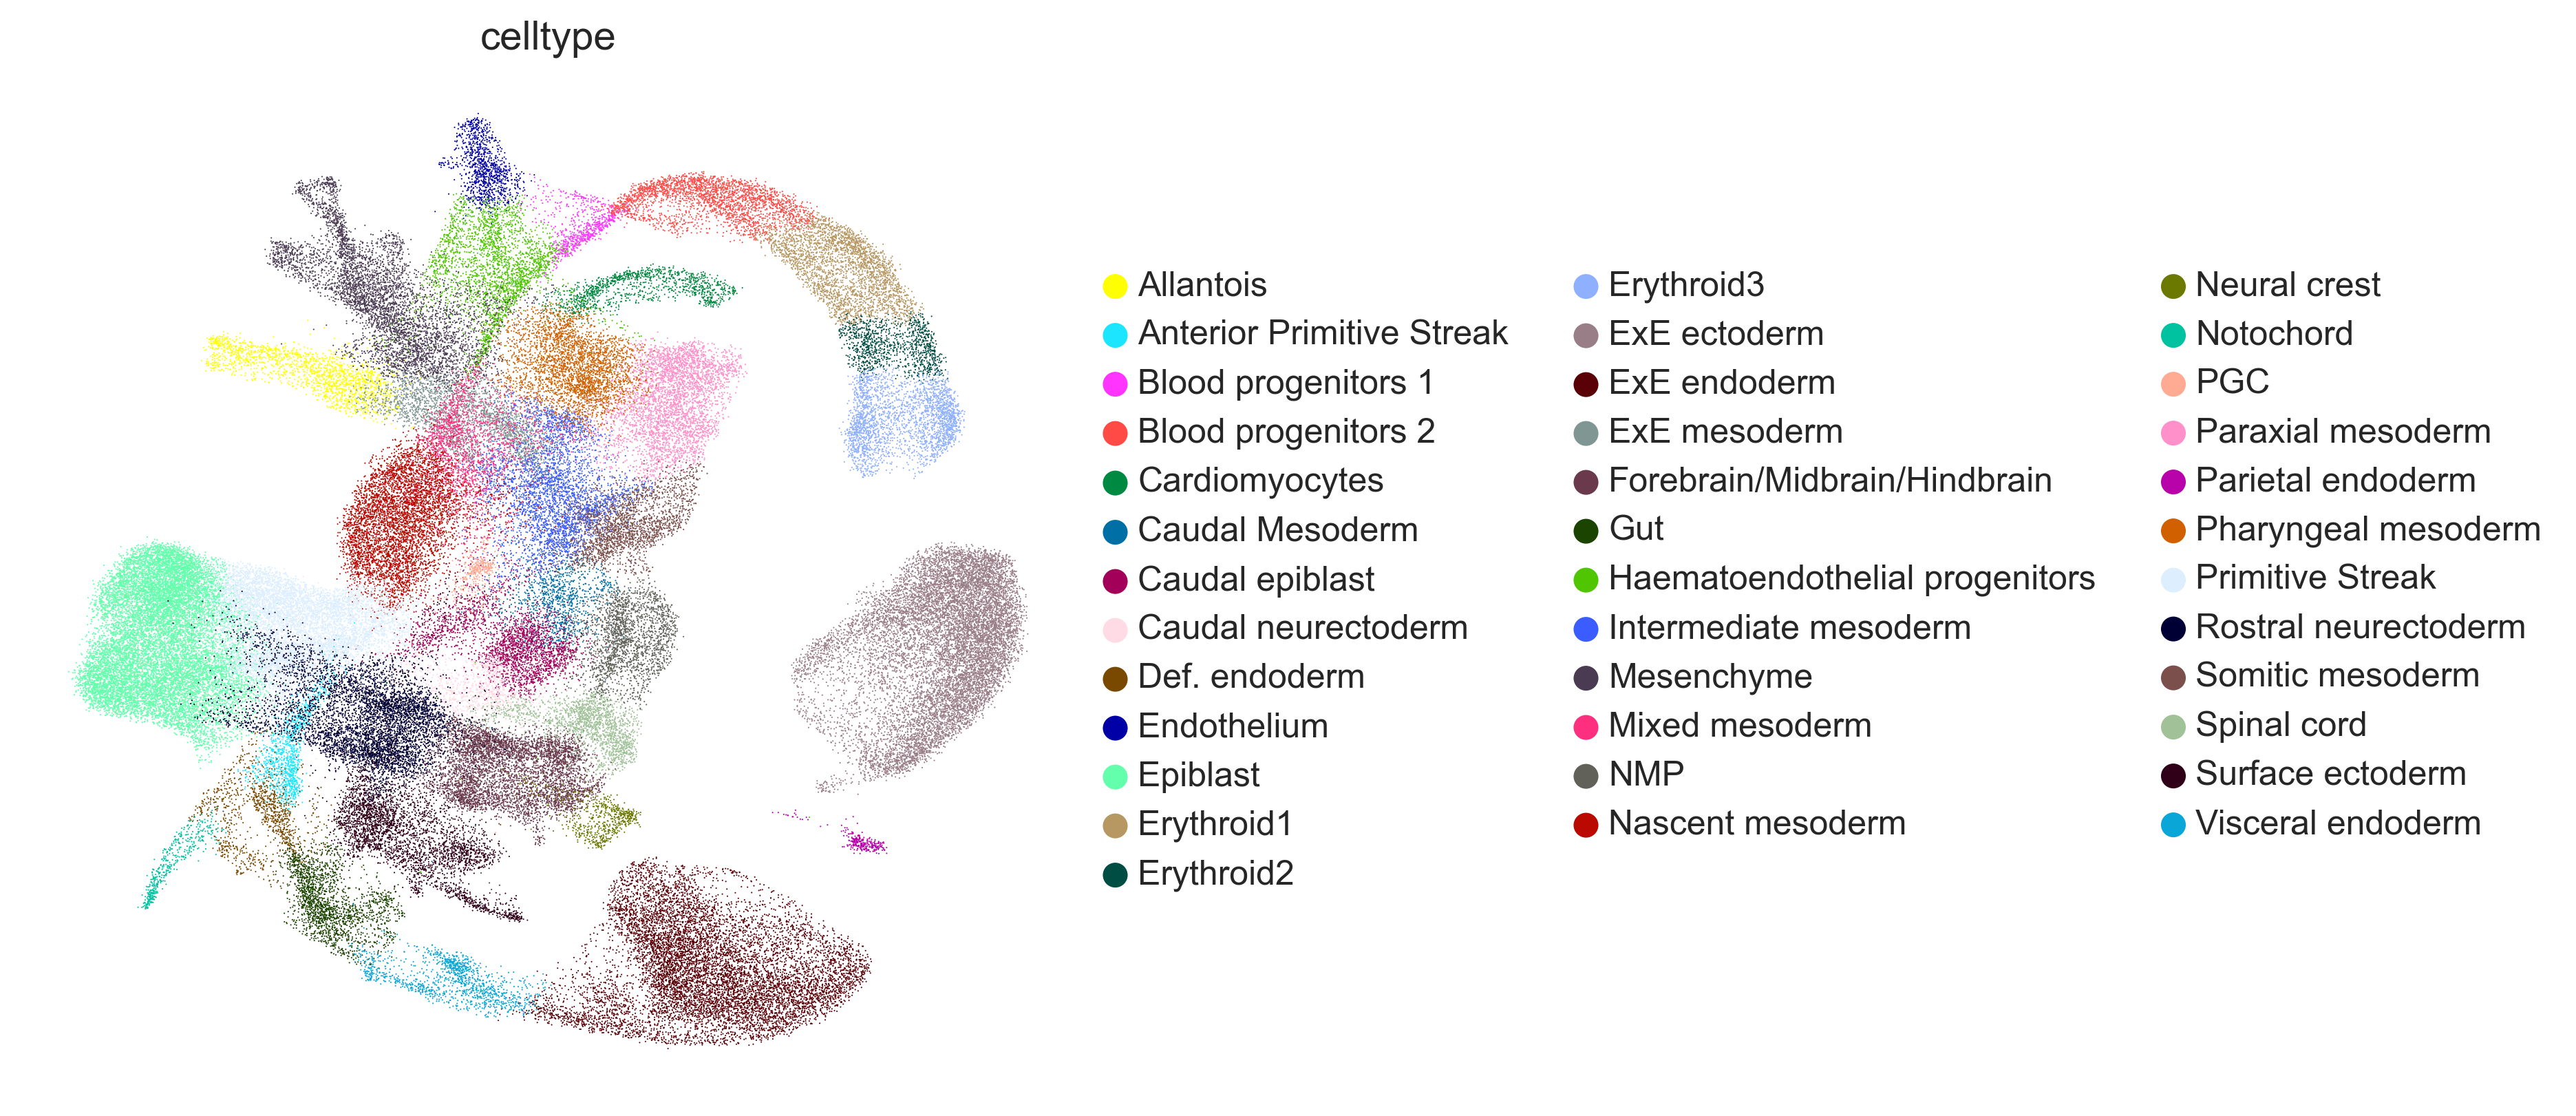

In [11]:
matplotlib.rcParams["figure.dpi"] = 150
matplotlib.rcParams["figure.figsize"] = [6, 6]
sc.pl.scatter(
    rna_ad,
    basis=plbasis,
    color=[
        ct_col,
    ],
    legend_fontsize=12,
    size=1,
)

In [14]:
if "custom_exclude" in exclude.keys():
    rna_ad.obs["custom_exclude"] = (rna_ad.obs[time_col] == "E7.0") & (
        rna_ad.obsm[f"X_{plbasis}"][:, 1] > 18
    )
    rna_ad.obs["custom_exclude"] = (
        rna_ad.obs["custom_exclude"].astype(str).astype("category")
    )

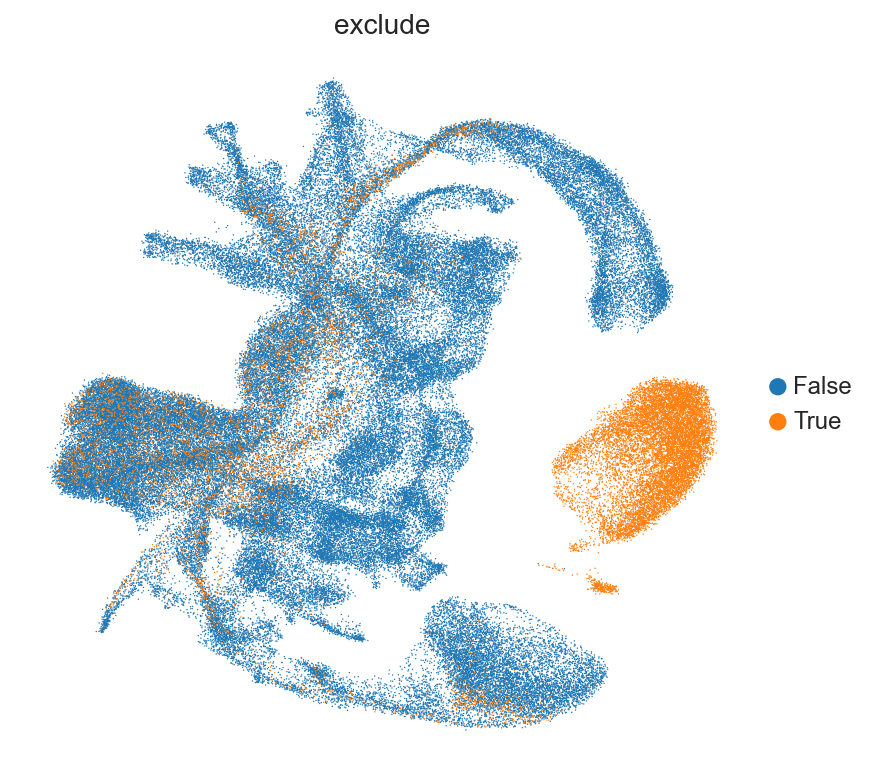

In [19]:
matplotlib.rcParams["figure.dpi"] = 72
matplotlib.rcParams["figure.figsize"] = [6, 6]
mask = get_mask(rna_ad.obs)
rna_ad.obs["exclude_mask"] = ~mask
rna_ad.obs["exclude"] = rna_ad.obs["exclude_mask"].astype("category")
sc.pl.scatter(
    rna_ad,
    basis=plbasis,
    color=[
        "exclude",
    ],
    legend_fontsize=12,
    size=2,
)

In [16]:
ad = rna_ad[mask, :].copy()

In [17]:
ad.obs["colored_celltypes"] = ad.obs[ct_col].copy()
colmapdict = {
    "Epiblast": "#635547",
    "Primitive Streak": "#DABE99",
    "Caudal epiblast": "#9E6762",
    "PGC": "#FACB12",
    "Anterior Primitive Streak": "#C19F70",
    "Notochord": "#0F4A9C",
    "Def. endoderm": "#F397C0",
    "Gut": "#EF5A9D",
    "Nascent mesoderm": "#C594BF",
    "Mixed mesoderm": "#DFCDE4",
    "Intermediate mesoderm": "#139992",
    "Caudal Mesoderm": "#3F84AA",
    "Paraxial mesoderm": "#8DB5CE",
    "Somitic mesoderm": "#005579",
    "Pharyngeal mesoderm": "#C9EBFB",
    "Cardiomyocytes": "#B51D8D",
    "Allantois": "#532C8A",
    "ExE mesoderm": "#8870AD",
    "Mesenchyme": "#CC7818",
    "Haematoendothelial progenitors": "#FBBE92",
    "Endothelium": "#FF891C",
    "Blood progenitors 1": "#F9DECF",
    "Blood progenitors 2": "#C9A997",
    "Erythroid1": "#C72228",
    "Erythroid2": "#F79083",
    "Erythroid3": "#EF4E22",
    "NMP": "#8EC792",
    "Rostral neurectoderm": "#65A83E",
    "Caudal neurectoderm": "#354E23",
    "Neural crest": "#C3C388",
    "Forebrain/Midbrain/Hindbrain": "#647A4F",
    "Spinal cord": "#CDE088",
    "Surface ectoderm": "#F7F79E",
    "Visceral endoderm": "#F6BFCB",
    "ExE endoderm": "#7F6874",
    "ExE ectoderm": "#989898",
    "Parietal endoderm": "#1A1A1A",
}
ad.uns["colored_celltypes_colors"] = [
    colmapdict.get(ct, "#DDDDDD") for ct in ad.obs["colored_celltypes"].cat.categories
]

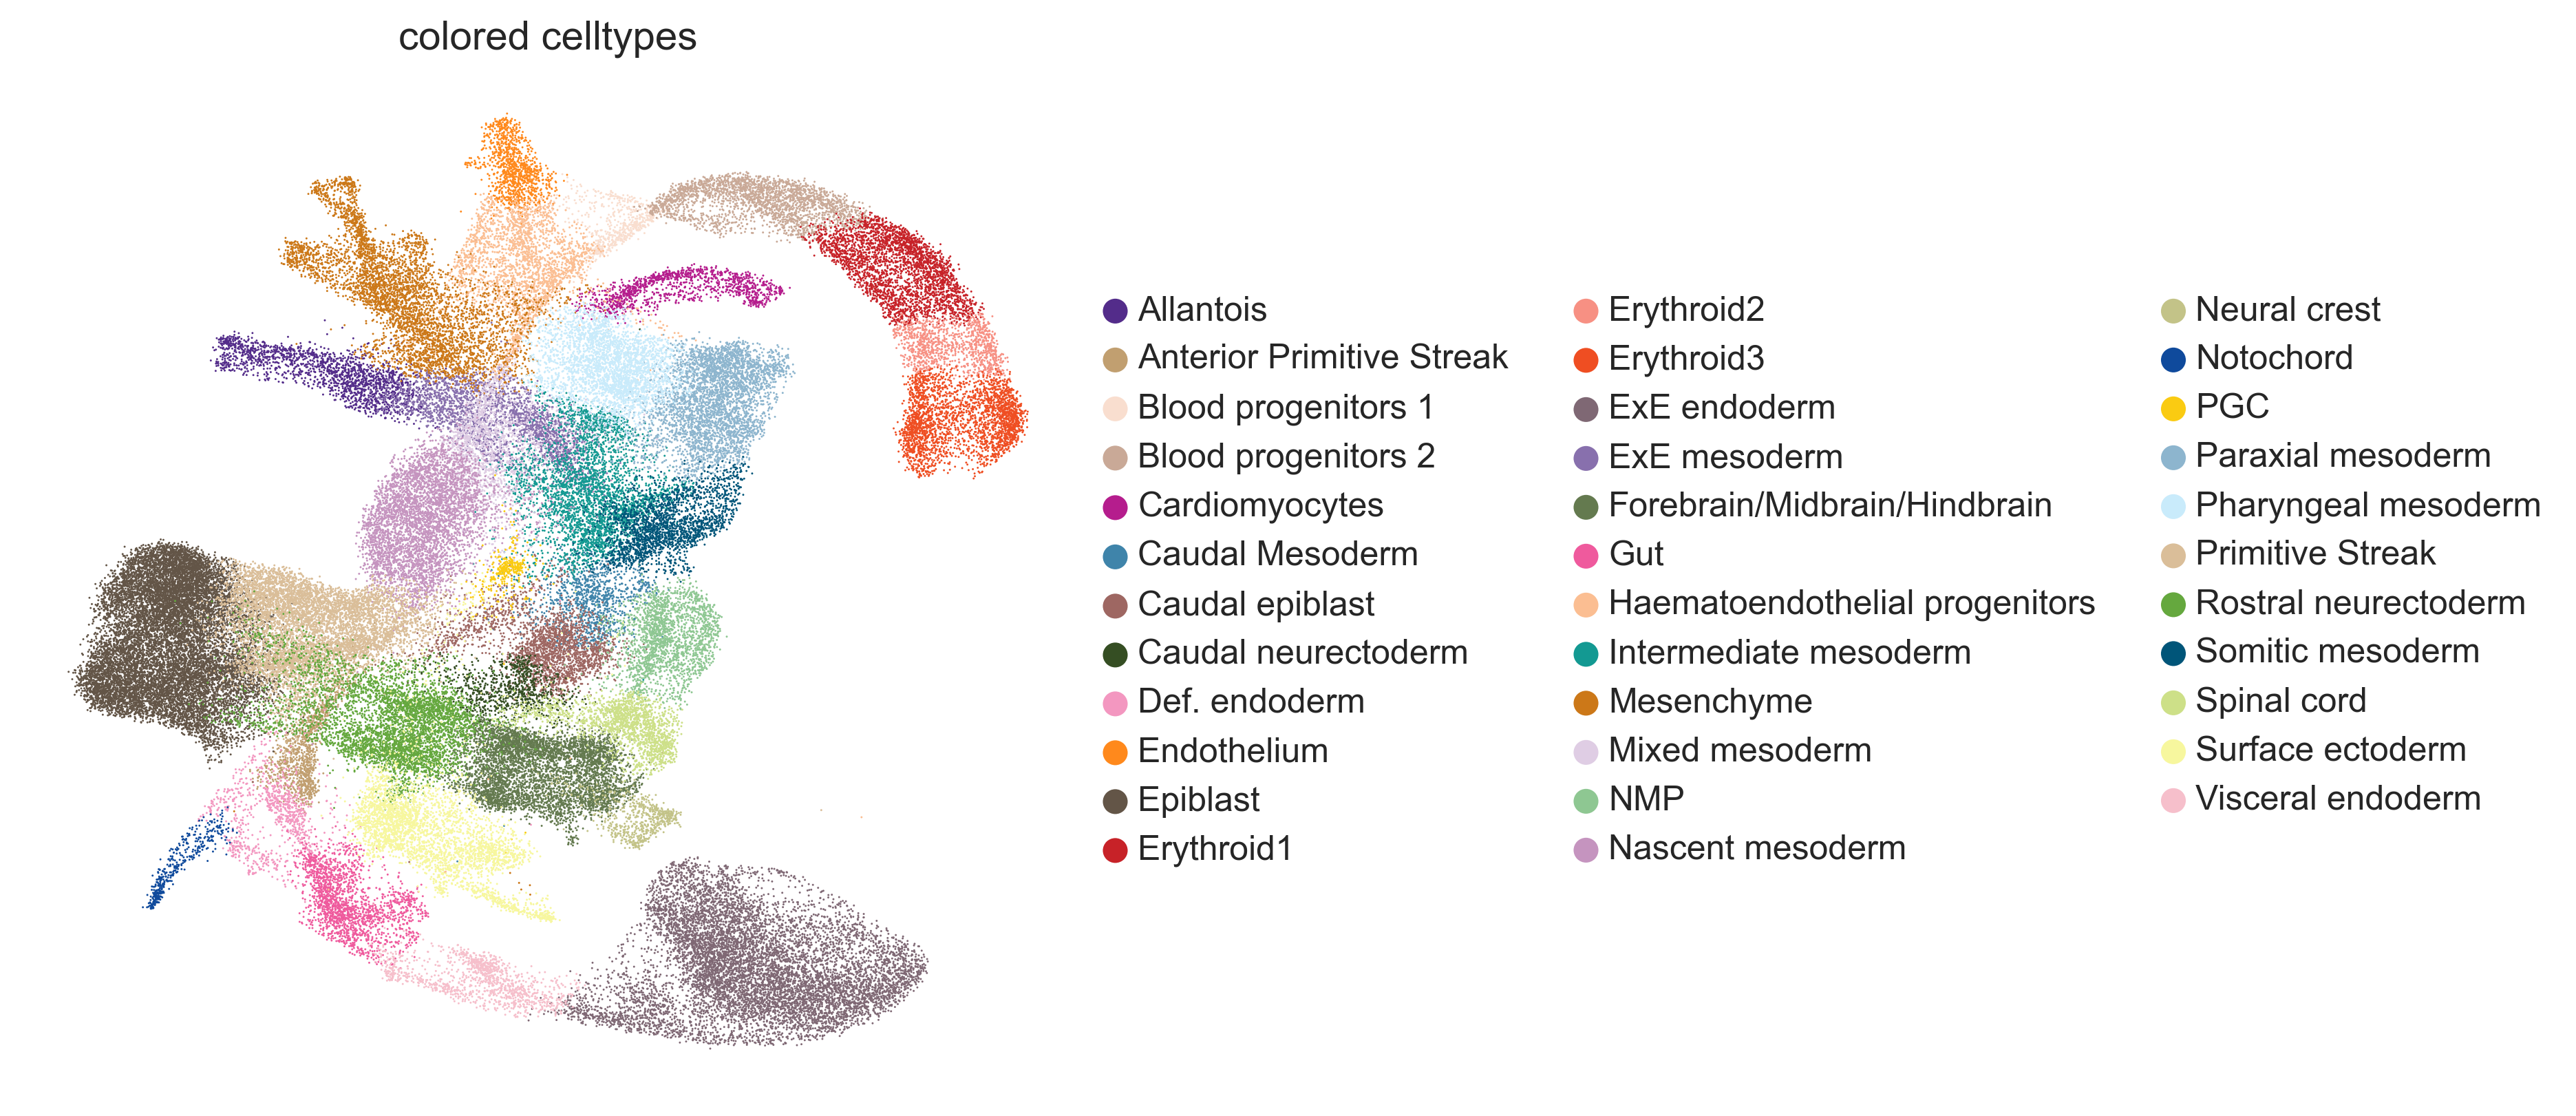

In [20]:
matplotlib.rcParams["figure.dpi"] = 150
matplotlib.rcParams["figure.figsize"] = [6, 6]
sc.pl.scatter(
    ad,
    basis=plbasis,
    color=[
        "colored_celltypes",
    ],
    legend_fontsize=12,
    size=2,
)

In [29]:
palantir.utils.run_diffusion_maps(ad, n_components=dm_ncomp)
palantir.utils.determine_multiscale_space(ad)
palantir.utils.run_magic_imputation(ad)
palantir.utils.run_local_variability(ad)
ad

Determing nearest neighbor graph...


/fh/fast/setty_m/user/dotto/mamba/envs/mellon_v2/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/fh/fast/setty_m/user/dotto/mamba/envs/mellon_v2/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/fh/fast/setty_m/user/dotto/mamba/envs/mel

AnnData object with n_obs × n_vars = 98145 × 16695
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'TP_density', 'custom_exclude', 'exclude_mask', 'exclude', 'stage_numerical', 'colored_celltypes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_colors', 'hvg', 'neighbors', 'pca', 'stage_colors', 'umap', 'exclude_colors', 'colored_celltypes_colors', 'DM_EigenValues'
    obsm: 'X_pca', 'X_umap', 'X_umap_paper', 'DM_EigenVectors'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'DM_Kernel', 'DM_Similarity'

Using cell_97713 for cell type ExE endoderm which is min in diffusion component 0.
Using cell_38185 for cell type Endothelium which is max in diffusion component 4.
Using cell_100358 for cell type Cardiomyocytes which is max in diffusion component 2.
Using cell_95567 for cell type Notochord which is min in diffusion component 9.
Using cell_135924 for cell type Erythroid3 which is max in diffusion component 0.
Using cell_96402 for cell type Allantois which is max in diffusion component 7.
Using cell_40791 for cell type Forebrain/Midbrain/Hindbrain which is max in diffusion component 3.


/fh/fast/setty_m/user/dotto/Palantir/src/palantir/utils.py:855: UserWarning: No valid component found: Neural crest Consider increasing the number of diffusion components ('n_components' in palantir.utils.run_diffusion_maps). The cell type Neural crest will be skipped.
  warn(
/loc/scratch/22456188/ipykernel_8596/836934759.py:6: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  highlights = terminal_states.append(pd.Series({early_cell:"Start"}))


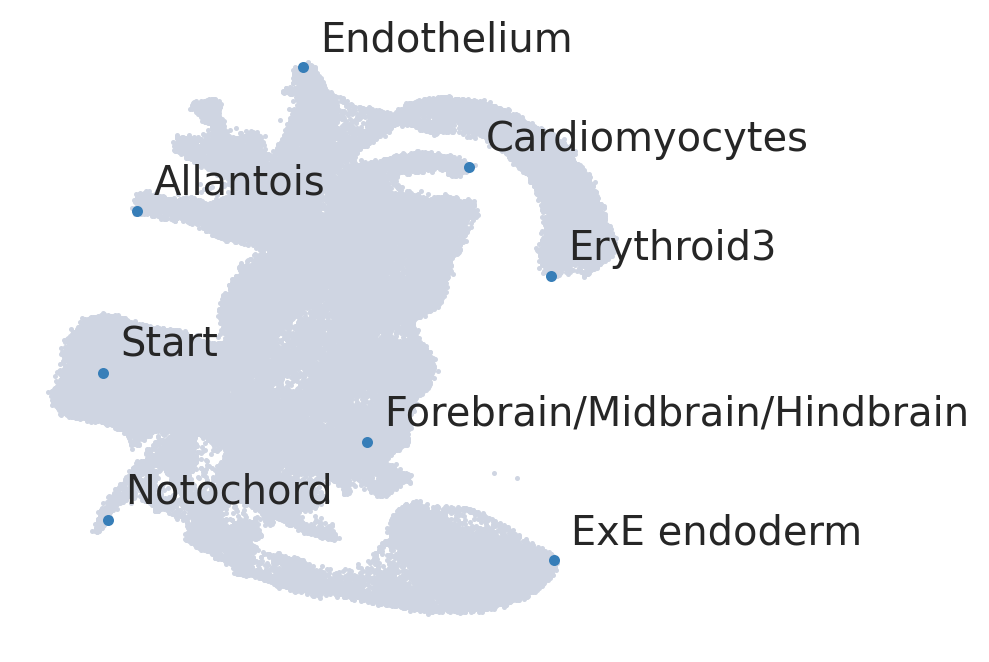

In [174]:
terminal_states = palantir.utils.find_terminal_states(
    ad,
    terminal_celltypes,
    ct_col,
)
highlights = terminal_states.append(pd.Series({early_cell:"Start"}))
palantir.plot.highlight_cells_on_umap(ad, highlights, embedding_bases=embedding_bases)
plt.show()

In [75]:
early_cell = palantir.utils.early_cell(ad, early_celltype, ct_col)
pr_res = palantir.core.run_palantir(
    ad,
    early_cell,
    terminal_states=terminal_states,
    use_early_cell_as_start=True,
    knn=50,
    num_waypoints=10_000,
)

Using cell_43031 for cell type Epiblast which is min in diffusion component 1.
Sampling and flocking waypoints...
Time for determining waypoints: 7.469162360827128 minutes
Determining pseudotime...
Shortest path distances using 50-nearest neighbor graph...
Time for shortest paths: 25.371546137332917 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9999
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


AnnData object with n_obs × n_vars = 98145 × 16695
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'TP_density', 'custom_exclude', 'exclude_mask', 'exclude', 'stage_numerical', 'colored_celltypes', 'palantir_pseudotime', 'palantir_entropy'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_colors', 'hvg', 'neighbors', 'pca', 'stage_colors', 'umap', 'exclude_colors', 'colored_celltypes_colors', 'DM_EigenValues', 'palantir_waypoints', 'palantir_fate_probabilities_columns', 'branch_masks_columns'
    obsm: 'X_pca', 'X_umap', 'X_umap_paper', 'DM_EigenVectors', 'DM_EigenVectors_multiscaled', 'palantir_f

In [163]:
masks = palantir.presults.select_branch_cells(ad, q=0.02)

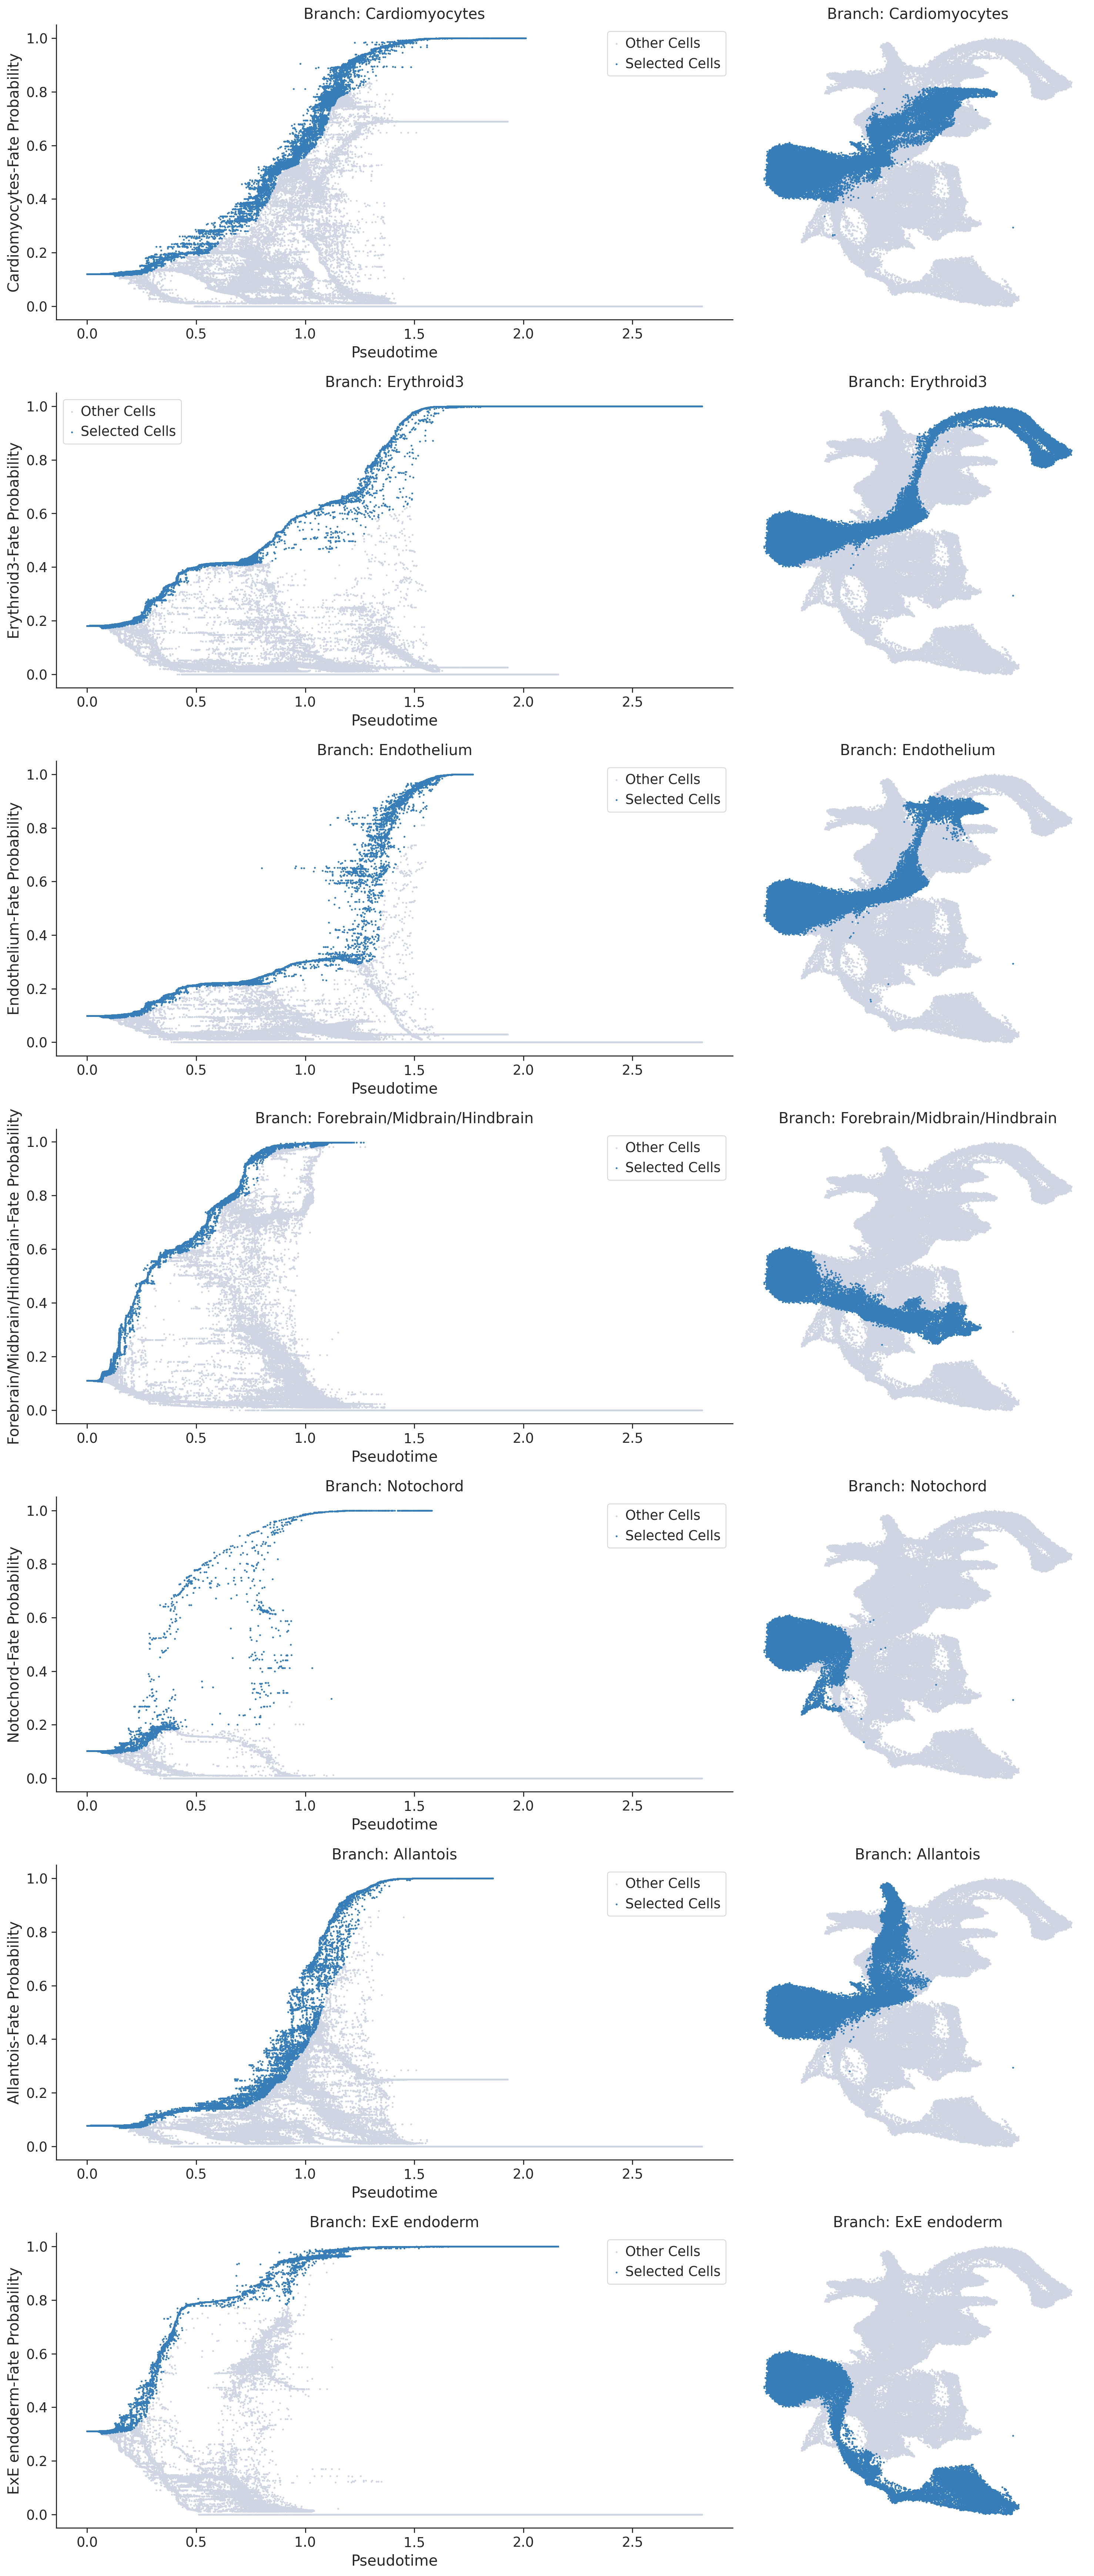

In [175]:
palantir.plot.plot_branch_selection(ad, s=1, embedding_bases=embedding_bases)
plt.show()

In [186]:
ad.write("/preprocessed_mouse-gastrulation-atlas.h5ad")